# 1. Conformance Classification

### Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

if __name__ == "__main__":
    # Read the XES file
    dataframe_log = pm4py.read_xes('../../data/logs/RequestForPayment.xes')

    # If 'log' is already a DataFrame, add the @@case_index column directly
    case_indices = {case_id: idx for idx, case_id in enumerate(dataframe_log['case:concept:name'].unique())}
    dataframe_log['@@case_index'] = dataframe_log['case:concept:name'].map(case_indices)
    
     # Convert the dataframe to event log
    log = log_converter.apply(dataframe_log)
    
dataframe_log

/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

,id,org:resource,concept:name,time:timestamp,org:role,case:Rfp_id,case:Project,case:Task,case:concept:name,case:OrganizationalEntity,case:Cost Type,case:RequestedAmount,case:Activity,case:RfpNumber,@@case_index
0,st_step 148220_0,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2017-01-09 08:17:18+00:00,EMPLOYEE,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
1,st_step 148221_0,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,2017-01-09 08:18:00+00:00,SUPERVISOR,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
2,st_step 148222_0,STAFF MEMBER,Request For Payment REJECTED by MISSING,2017-01-10 11:42:32+00:00,MISSING,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
3,st_step 148219_0,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2017-03-03 08:51:13+00:00,EMPLOYEE,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
4,st_step 148218_0,STAFF MEMBER,Request For Payment APPROVED by PRE_APPROVER,2017-03-03 08:51:42+00:00,PRE_APPROVER,request for payment 148214,project 148216,UNKNOWN,request for payment 148214,organizational unit 65463,0,34.336343,UNKNOWN,request for payment number 148215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36791,st_step 185004_0,STAFF MEMBER,Request For Payment APPROVED by ADMINISTRATION,2018-12-29 11:35:02+00:00,ADMINISTRATION,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885
36792,st_step 185003_0,STAFF MEMBER,Request For Payment APPROVED by BUDGET OWNER,2019-01-03 08:27:20+00:00,BUDGET OWNER,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885
36793,st_step 185005_0,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,2019-01-08 08:00:39+00:00,SUPERVISOR,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885
36794,rp_request for payment 185000_15,SYSTEM,Request Payment,2019-01-08 08:29:14+00:00,UNDEFINED,request for payment 185000,project 147860,task 152704,request for payment 185000,organizational unit 65468,0,15.409660,activity 505,request for payment number 185001,6885


### Discover Process Model

In [2]:
import pm4py
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(log)

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


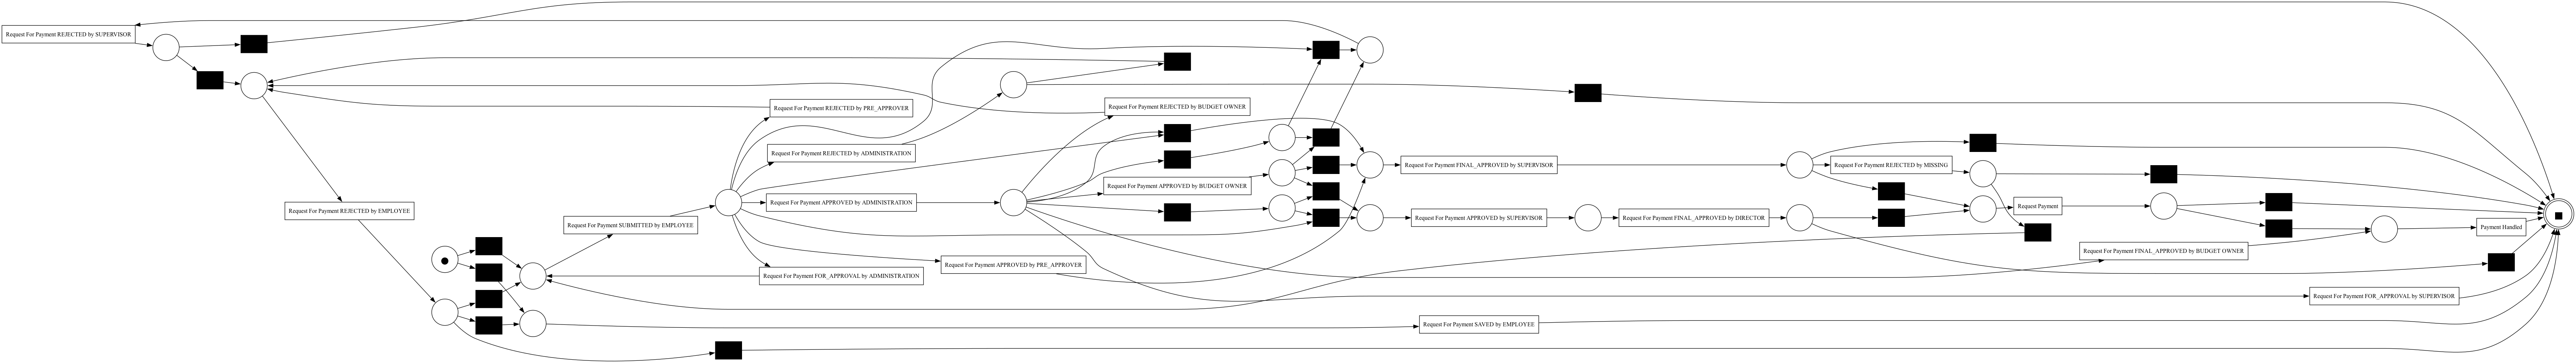

In [3]:
pm4py.view_petri_net(net, initial_marking, final_marking)

### Alignment between discovered model and log

In [4]:
def generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking):
    from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
    from pm4py.algo.conformance.alignments.petri_net import variants
    from pm4py.objects.petri_net.utils import align_utils
    max_events=0
    for trace in log:
        counter=0
        for event in trace:
            counter+=1
        if counter > max_events:
            max_events=counter
    parameters={}
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_SYNC_COST_FUNCTION] = list(map(lambda i: .1*i, range(max_events*2)))
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_TRACE_COST_FUNCTION]=list(map(lambda i: align_utils.STD_MODEL_LOG_MOVE_COST-.1*i, range(max_events*2)))
    aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking, variant=variants.state_equation_a_star, parameters=parameters)
    return aligned_traces

In [5]:
alignment_discovered_model = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

### Alignment between ground truth model and log

In [6]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/model/Model_RequestForPayment.bpmn")

# 3. Convert the BPMN to a Petri net
net2, initial_marking2, final_marking2 = pm4py.convert_to_petri_net(bpmn_graph)

alignment_ground_truth = generate_alignments_adjusted_tracecost_pkl(log, net2, initial_marking2, final_marking2)

aligning log, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

In [36]:
alignment_ground_truth[6]

{'alignment': [('>>', None),
  ('Request For Payment SUBMITTED by EMPLOYEE',
   'Request For Payment SUBMITTED by EMPLOYEE'),
  ('>>', 'Request For Payment APPROVED by ADMINISTRATION'),
  ('>>', None),
  ('>>', None),
  ('Request For Payment FINAL_APPROVED by SUPERVISOR',
   'Request For Payment FINAL_APPROVED by SUPERVISOR'),
  ('Request Payment', 'Request Payment'),
  ('Payment Handled', 'Payment Handled')],
 'cost': 10003,
 'visited_states': 8,
 'queued_states': 25,
 'traversed_arcs': 25,
 'lp_solved': 3,
 'fitness': 0.9761904761904762,
 'bwc': 429924.0}

In [37]:
alignment_discovered_model[6]

{'alignment': [('>>', None),
  ('Request For Payment SUBMITTED by EMPLOYEE',
   'Request For Payment SUBMITTED by EMPLOYEE'),
  ('>>', 'Request For Payment APPROVED by PRE_APPROVER'),
  ('Request For Payment FINAL_APPROVED by SUPERVISOR',
   'Request For Payment FINAL_APPROVED by SUPERVISOR'),
  ('>>', None),
  ('Request Payment', 'Request Payment'),
  ('>>', None),
  ('Payment Handled', 'Payment Handled')],
 'cost': 10003,
 'visited_states': 8,
 'queued_states': 28,
 'traversed_arcs': 28,
 'lp_solved': 1,
 'fitness': 0.975,
 'bwc': 409923.0}

# 1. Conformance Classification

In [7]:
# Extract fitness values
alignment_ground_truth_fitness = [trace['fitness'] for trace in alignment_ground_truth]
alignment_discovered_model_fitness = [trace['fitness'] for trace in alignment_discovered_model]

# Create DataFrame
df_fitness = pd.DataFrame({
    'ground_truth_fit': alignment_ground_truth_fitness,
    'predicted_fit': alignment_discovered_model_fitness
})

In [8]:
df_fitness

,ground_truth_fit,predicted_fit
0,0.880952,0.975
1,0.976190,0.975
2,0.928571,0.925
3,0.880952,0.975
4,0.880952,0.975
...,...,...
6881,1.000000,0.975
6882,1.000000,0.975
6883,1.000000,0.975
6884,1.000000,1.000


In [9]:
# deviating: 1
# conform: 0

df_conformance = pd.DataFrame()
df_conformance['actual'] = df_fitness['ground_truth_fit'].apply(lambda x: 1 if x < 1 else 0)
df_conformance['predicted'] = df_fitness['predicted_fit'].apply(lambda x: 1 if x < 1 else 0)

In [10]:
# Calculating TP, TN, FP, FN
TP = ((df_conformance['actual'] == 1) & (df_conformance['predicted'] == 1)).sum()
TN = ((df_conformance['actual'] == 0) & (df_conformance['predicted'] == 0)).sum()
FP = ((df_conformance['actual'] == 0) & (df_conformance['predicted'] == 1)).sum()
FN = ((df_conformance['actual'] == 1) & (df_conformance['predicted'] == 0)).sum()

In [11]:
precision_dev = TP / (TP + FP)
print(f"Precision Dev: {precision_dev:.2f}")

Precision Dev: 0.25


In [12]:
recall_dev = TP / (TP + FN)
print(f"Recall Dev: {recall_dev:.2f}")

Recall Dev: 0.61


In [13]:
precision_no_dev = TN / (TN + FN)
print(f"Precision No Dev: {precision_no_dev:.2f}")

Precision No Dev: 0.76


In [14]:
recall_no_dev = TN / (TN + FP)
print(f"Recall No Dev: {recall_no_dev:.2f}")

Recall No Dev: 0.41


In [15]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(df_conformance['actual'], df_conformance['predicted'])
print(f"AUC-ROC: {auc_roc:.2f}")

AUC-ROC: 0.51


# 2. Conformance Diagnostics

In [16]:
# Diagnostics only for deviating traces:

# Find indices where 'predicted' column has value 1
indices_to_keep = df_conformance[df_conformance['predicted'] == 1].index.tolist()

# Filter the lists to keep only the indices where 'predicted' is 1
alignment_discovered_model = [alignment_discovered_model[i] for i in indices_to_keep]
alignment_ground_truth = [alignment_ground_truth[i] for i in indices_to_keep]

In [17]:
# Function to extract log and model moves excluding (None, >>) and (>>, None)
def extract_moves(alignment):
    log_moves = [move for move in alignment if move[1] == '>>' and move[0] is not None]
    model_moves = [move for move in alignment if move[0] == '>>' and move[1] is not None]
    return log_moves, model_moves

# Initialize counts for moves
total_log_moves = 0
total_no_log_moves = 0
total_model_moves = 0
total_no_model_moves = 0

# Initialize counts for TP, FP, FN, TN
tp_log_moves = 0
fp_log_moves = 0
fn_log_moves = 0
tn_log_moves = 0

tp_model_moves = 0
fp_model_moves = 0
fn_model_moves = 0
tn_model_moves = 0

# Iterate through aligned traces and count moves
for i, aligned_trace in enumerate(alignment_ground_truth):
    log_moves_gt, model_moves_gt = extract_moves(aligned_trace['alignment'])
    total_log_moves += len(log_moves_gt)
    total_no_log_moves += sum(1 for move in aligned_trace['alignment'] if move[1] != '>>' or move[0] is None)
    total_model_moves += len(model_moves_gt)
    total_no_model_moves += sum(1 for move in aligned_trace['alignment'] if move[0] != '>>' or move[1] is None)
    
    if i < len(alignment_discovered_model):
        log_moves_input, model_moves_input = extract_moves(alignment_discovered_model[i]['alignment'])
        
        # Calculate TP, FP, FN, TN for log moves
        tp_log_moves += sum(1 for move in log_moves_gt if move in log_moves_input)
        fn_log_moves += sum(1 for move in log_moves_gt if move not in log_moves_input)
        fp_log_moves += sum(1 for move in log_moves_input if move not in log_moves_gt)
        tn_log_moves += sum(1 for move in aligned_trace['alignment'] if move not in log_moves_gt and move not in log_moves_input and move[1] != '>>' and move[0] != '>>')
        
        # Calculate TP, FP, FN, TN for model moves
        tp_model_moves += sum(1 for move in model_moves_gt if move in model_moves_input)
        fn_model_moves += sum(1 for move in model_moves_gt if move not in model_moves_input)
        fp_model_moves += sum(1 for move in model_moves_input if move not in model_moves_gt)
        tn_model_moves += sum(1 for move in aligned_trace['alignment'] if move not in model_moves_gt and move not in model_moves_input and move[1] != '>>' and move[0] != '>>')

# Calculate recall, precision, F1 score for log moves
recall_log_moves = tp_log_moves / (tp_log_moves + fn_log_moves) if (tp_log_moves + fn_log_moves) > 0 else 0
precision_log_moves = tp_log_moves / (tp_log_moves + fp_log_moves) if (tp_log_moves + fp_log_moves) > 0 else 0

# Calculate recall, precision, F1 score for model moves
recall_model_moves = tp_model_moves / (tp_model_moves + fn_model_moves) if (tp_model_moves + fn_model_moves) > 0 else 0
precision_model_moves = tp_model_moves / (tp_model_moves + fp_model_moves) if (tp_model_moves + fp_model_moves) > 0 else 0



# Print results for log moves
print(f"Precision (Log Moves): {precision_log_moves:.2f}")
print(f"Recall (Log Moves): {recall_log_moves:.2f}")
print("")

# Print results for model moves
print(f"Precision (Model Moves): {precision_model_moves:.2f}")
print(f"Recall (Model Moves): {recall_model_moves:.2f}")

Precision (Log Moves): 0.04
Recall (Log Moves): 0.03

Precision (Model Moves): 0.00
Recall (Model Moves): 0.00


In [18]:
# Filter the other dataframe using the indices_to_keep
df_fitness = df_fitness.loc[indices_to_keep]

In [19]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(df_fitness['ground_truth_fit'], df_fitness['predicted_fit'])

# Print the MSE restricted to 4 decimal places
print(f"The Mean Squared Error (MSE) is: {mse:.4f}")

The Mean Squared Error (MSE) is: 0.0007
